In [12]:
import pandas as pd
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import sys
import os
import pickle

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import MACCSkeys

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score


In [2]:
data_folder = 'raw_data/'
data_source = '1 Supplemental Excel data.xlsx'
data_source_non = "Non-PBT.xlsx"
robcmr = 'Excluded in robustness check 2 - CMR'
robpbt = 'Excluded in robustness check 2 - PBT/vPvB'
fp_cols = ['SMILES']

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
chems_data  = pd.read_excel(data_folder+data_source, sheet_name = 1, header=1)
non_pbt = pd.read_excel(data_folder+data_source_non)
non_pbt = non_pbt['SMILES']
non_pbt = pd.concat([non_pbt, pd.DataFrame(np.zeros([481]), columns=["PBT/vPvB"])], axis=1)

In [4]:
chems_ext = chems_data[fp_cols+['CMR']].loc[chems_data[robcmr] == 0]
chems_maccs = chems_data[fp_cols+['PBT/vPvB']].loc[chems_data[robpbt] == 0]
chems_maccs_non = pd.concat([chems_maccs, non_pbt], axis=0)

# chems_data['CM'] = np.where((chems_data['C'] == 1) | (chems_data['M'] == 1), 1, 0)
# chems_cm = chems_data[fp_cols+['CM']].loc[chems_data[robcmr] == 0]
# chems_r = chems_data[fp_cols+['R']].loc[chems_data[robcmr] == 0]

In [6]:
#remove not parseable molecules
if chems_maccs_non.shape[0] == 975:
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[506])
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[751])
    chems_maccs_non = chems_maccs_non.drop(chems_maccs_non.index[794])

In [64]:
def maccs_som(dataset, soms_smarts, cyps, tox):
    ml_data = []
    for mol_idx in range(dataset.shape[0]):
        mcule = Chem.MolFromSmiles(dataset['SMILES'].iloc[mol_idx])
        
        FPs = MACCSkeys.GenMACCSKeys(mcule).ToBitString()
#         FPs = AllChem.GetMorganFingerprintAsBitVect(x,4,useFeatures=True,nBits=1024).ToBitString()
#         FPs = AllChem.GetMorganFingerprintAsBitVect(x,4,nBits=1024).ToBitString()
        
        if cyps:
            mol_feats = np.zeros([len(FPs)+len(soms_smarts),1])
        else:
            mol_feats = np.zeros([len(FPs),1])

        for i in range(len(FPs)):
            if int(FPs[i]) == 1:
                mol_feats[i] += 1
        
        if cyps:               
            for i in range(71):
                cyp_idx_feats = mcule.GetSubstructMatches(Chem.MolFromSmarts(cyp_metabol_feats['SMARTS'].iloc[i]))
                for c in cyp_idx_feats:
                    mol_feats[i+166] += 1
        ml_data.append([dataset['SMILES'].iloc[mol_idx], dataset[tox].iloc[mol_idx], mol_feats.ravel()])
    return ml_data

In [68]:
cyp_metabol_feats = pd.read_excel(data_folder + "output.xls")
dat = maccs_som(chems_maccs, cyp_metabol_feats, False, "PBT/vPvB")
dat = pd.DataFrame(dat)

In [46]:
#Grid search Random Forest Classifier

X = dat[2].values
y = dat[1].values
X = [[int(number) for number in group] for group in X]

param_grid = { 
    'n_estimators': [200,500,1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,6,8,12],
    'criterion' :['gini', 'entropy']
}
    
for i in range(5):
    print(i)
    rfc=RandomForestClassifier(random_state=i)
    CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv = 5)
    CV_rfc.fit(X, y)
    print(CV_rfc.best_params_)

0
{'criterion': 'gini', 'max_depth': 12, 'max_features': 'auto', 'n_estimators': 200}
1
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 500}
2
{'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 1000}
3
{'criterion': 'entropy', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 500}
4
{'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 1000}


In [69]:
#Grid search Support Vector Classifier

X = dat[2].values
y = dat[1].values
X = [[int(number) for number in group] for group in X]

param_grid = [{
'kernel': ['rbf'], 
'gamma': [1e-2, 1e-3, 1e-4],
'C': [1, 10, 100, 1000]},{
'kernel': ['linear'], 
'C': [1, 10, 100, 1000]}]
    
for i in range(5):
    print(i)
    clf = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
    clf.fit(X, y)
    print(clf.best_params_)

0
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
1
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
2
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
3
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
4
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [67]:
for i in range(40):
    skf = StratifiedKFold(n_splits=10, random_state=i, shuffle=True)
    X = dat[2].values
    y = dat[1].values
    X = [[int(number) for number in group] for group in X]
    skf.get_n_splits(X, y)
    X = np.array(X)
    bac=[]
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(C=100, kernel='rbf', gamma=1e-2)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bac.append(balanced_accuracy_score(y_test,y_pred))
    print(np.mean(bac), np.std(bac))

0.8039955658376711 0.0349409801188955
0.8019763618447829 0.04958080695678283
0.8162077201550885 0.04004492026864912
0.8205358481674271 0.042510149255898404
0.8060573442152389 0.05294555997967967
0.8073731336889232 0.05504583491096831
0.8049062292483343 0.030830144163423126
0.8280958807274598 0.03600839133996594
0.8186143778249042 0.045791446339487576
0.8121267377846326 0.04854502110560572
0.8174134588608274 0.04170975744965583
0.8262453676927362 0.051225897654691925
0.8264127198337725 0.03524027762083244
0.8187279095173832 0.024941165361670646
0.8011687873529979 0.06287389063391698
0.8138037401195296 0.0572009340296406
0.8200436989910674 0.04620104508148722
0.8100060514534198 0.05301177999872312
0.8111544887860678 0.06349618651068431
0.8069958550221706 0.030735275462555757
0.8197116723432514 0.042576920791916995
0.8032656427393269 0.0640417690461158
0.8120801469485679 0.04840137911088678
0.8129961656277447 0.027917241604619458
0.8181141957457747 0.04591934613980879
0.814783218730587 0.

In [51]:
for i in range(40):
    skf = StratifiedKFold(n_splits=10, random_state=i, shuffle=True)
    X = dat[2].values
    y = dat[1].values
    X = [[int(number) for number in group] for group in X]
    skf.get_n_splits(X, y)
    X = np.array(X)
    bac=[]
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = SVC(C=100, kernel='rbf', gamma=1e-2)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bac.append(balanced_accuracy_score(y_test,y_pred))
    print(np.mean(bac), np.std(bac))

0.8860993657505286 0.07805643135380694
0.8912125357542594 0.04517418092145975
0.8987746134394559 0.04982335762288152
0.8905586991667704 0.03570782325133618
0.8852880031505203 0.05066034556452207
0.8830886498362558 0.056465880451444635
0.8900565850018655 0.05355474812035249
0.8827167019027484 0.037578669957665435
0.8730307175724412 0.047246569900842625
0.8743168345562327 0.0865916479276533
0.878463914106869 0.05666017508054892
0.8832844173610248 0.05882149925374523
0.8870458690875929 0.056980556412895414
0.8904950669485554 0.06663694647576686
0.881553911205074 0.057463060019886936
0.8586103511171912 0.0974878598289361
0.873240164987771 0.05571579057752537
0.8955954897815364 0.06988165209229905
0.8782945736434108 0.06656522988982874
0.8890895618289599 0.039575188597188664
0.8859026655059488 0.04596188108784962
0.8781712473572938 0.047586031612662665
0.8855042905111304 0.053910077948675986
0.8872680636736725 0.04018817734390727
0.8861257928118393 0.05404898015673659
0.8860788459146873 0.0

In [47]:
for i in range(15):
    skf = StratifiedKFold(n_splits=10, random_state=i, shuffle=True)
    X = dat[2].values
    y = dat[1].values
    X = [[int(number) for number in group] for group in X]
    skf.get_n_splits(X, y)
    X = np.array(X)
    bac=[]
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(criterion='gini', max_depth=15, max_features='log2', n_estimators=500)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        bac.append(balanced_accuracy_score(y_test,y_pred))
    print(np.mean(bac), np.std(bac))

0.8537085976039464 0.0880396793970013
0.8502995066948555 0.06933878966857439
0.8539043651287154 0.08904983270691633
0.862623326286117 0.032493591661810185
0.8663779380674047 0.0454335022208045
0.8550475687103594 0.06245884043764074
0.8586260000829086 0.060972512319844255
0.850123326286117 0.04353323427418601
0.8588354474982381 0.04881480742060638
0.8521866061435144 0.10118127789022098
0.8485817477096547 0.06510726028203323
0.8588286075529578 0.06561676404842579
0.8633809020436928 0.0563243621000257
0.8576990838618744 0.052260425261711284
0.8540873854827342 0.059287524265878085


In [43]:
maccs_lab = ["maccs" + str(i+1) for i in range(167)]
som_lab = ["som" + str(i+1) for i in range(71)]
labs = maccs_lab+som_lab


               0
maccs1  0.000000
maccs2  0.000000
maccs3  0.000000
maccs4  0.002361
maccs5  0.000000
...          ...
som67   0.000000
som68   0.000000
som69   0.000000
som70   0.000000
som71   0.000000

[238 rows x 1 columns]


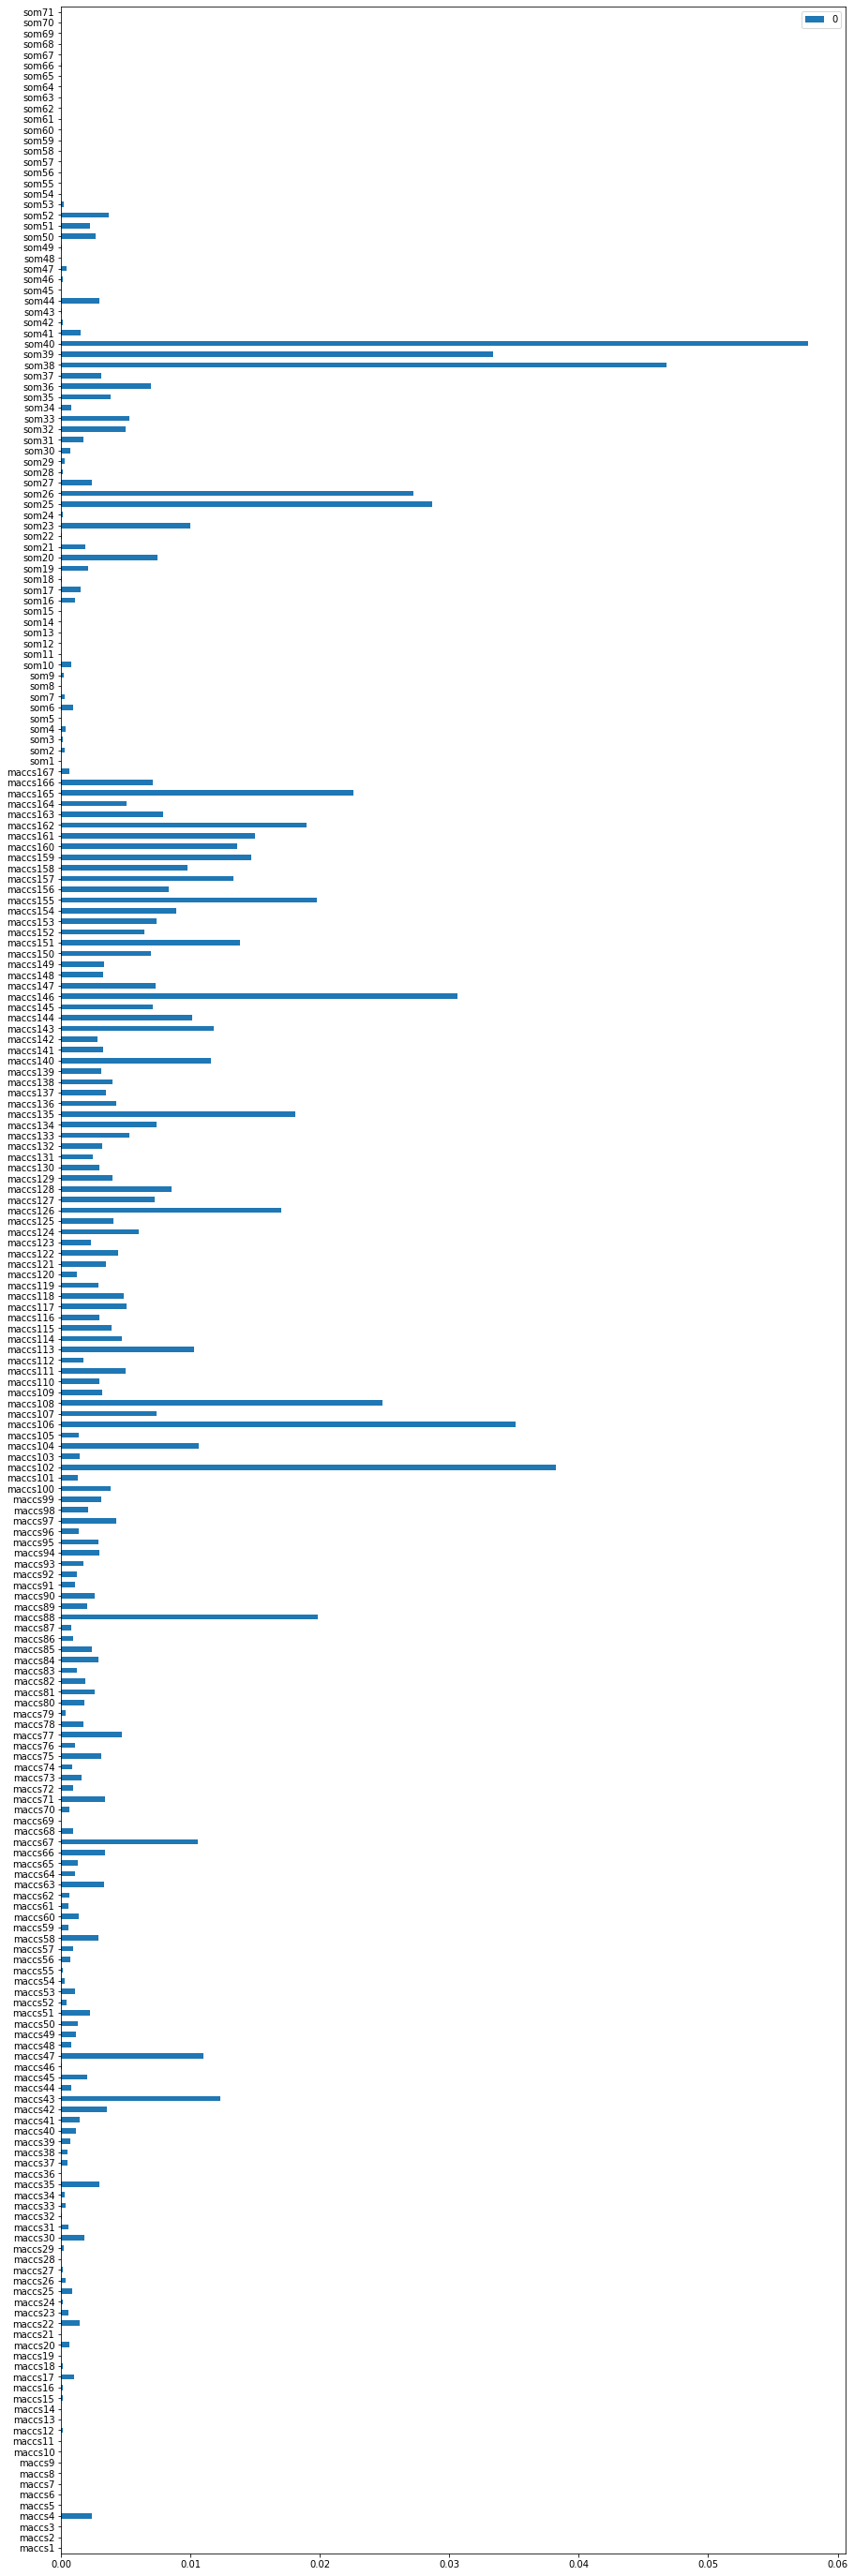

In [45]:
feature_importances = pd.DataFrame(clf.feature_importances_, index=labs)
feature_importances.plot.barh(figsize=(15,50))